## Section 5.1 Counting Expirement Python Implementation

Link to paper: https://arxiv.org/pdf/1007.1727.pdf  
See page 22 for section 5.1 description.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from scipy.special import gamma
import random

%matplotlib inline

In [2]:
# Since computers are bad at comparing floats we should create a value that represents 0
EPSILON = 1e-10

In [3]:
def pdf_mu0(q_0):
    """ Formula for pdf at mu=0. See Eqn. 49 on page 14 """
    
    delta_t = 0 if q_0 > EPSILON else 0.5 # delta term
    q_0 = max(q_0, EPSILON) # avoid 0 to a negative power
    return delta_t + (8 * np.pi * q_0) ** -0.5 * np.exp(-0.5 * q_0)

In [4]:
pdf_mu0(0)

19947.614019074277

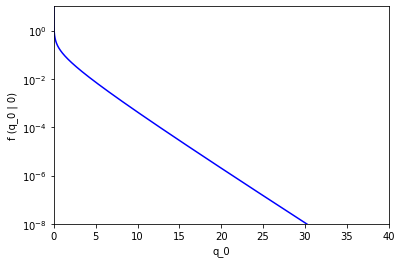

In [5]:
""" Plot pdf at mu = 0"""

# Format axes
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlim([0, 40])
axes.set_xlabel('q_0')
axes.set_ylabel('f (q_0 | 0)')
plt.rcParams["figure.figsize"] = [5, 5]

# Plot f(q_0 | 0)
x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(pdf_mu0)(x) # get vector of pdf_mu0 applied to every element of x
plt.plot(x, pdfs, color="blue")

plt.show()

In [6]:
# Define some hyperparameters
b = 2
tau = 10
mu = 0
s = 10 # for mu = 0 signal value doesn't really matter
gen_num = 10_000

In [7]:
# Calculate expectations for m and n
E_m = tau * b
E_n = mu * s + b
print(f"E[m]: {E_m} E[n]: {E_n}")

# Generate m and n values along a poisson distribution
ms = [poisson.ppf(random.uniform(0,1), E_m) for i in range(0, gen_num)]
ns = [poisson.ppf(random.uniform(0,1), E_n) for i in range(0, gen_num)]

E[m]: 20 E[n]: 2


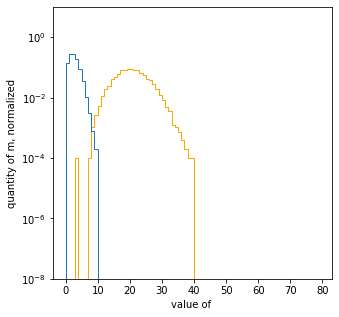

In [8]:
# Check m, n distributions look ok
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlabel('value of ')
axes.set_ylabel('quantity of m, normalized')
plt.hist(ms, bins=range(80), histtype='step', density=True, color='orange')
plt.hist(ns, bins=range(80), histtype='step', density=True)
plt.show()

In [9]:
def get_likelihood(n, m, mu, b, s=s, tau=tau):
    """ Calculate L(mu, b). Since this is only single bin, 
    we just multiply two terms together. See Eqn. 90 on page 23. """
    t1 = (mu * s + b) ** n / gamma(n) * np.exp(-(mu * s + b))
    t2 = (tau * b) ** m / gamma(m) * np.exp(-tau * b)
    return t1 * t2

In [19]:
""" To find the test statistics q_0, q_mu and ~q_mu, we require the ML estimators mu_hat,
b_hat as well as the conditional ML estimator b_hat_hat for a specified mu. Page 23."""

def get_mu_hat(n, m, s=s, tau=tau):
    """ See Eqn. 91 """
    return (n - m / tau) / s

def get_b_hat(m, tau=tau):
    """ See Eqn. 92 """
    return m / tau

def get_b_2hat(n, m, mu, tau=tau):
    """ See Eqn. 93 """
    t1 = (n + m - (1 + tau) * mu * s) / 2 / (1 + tau)
    t2 = (n + m - (1 + tau * mu * s)) ** 2 + 4 * (1 + tau) * m * mu * s
    t2 /= 4 * (1 + tau) ** 2
    t2 **= 1 / 2
    return t1 + t2

In [11]:
def get_lambda(n, m, mu):
    """ Get profile likelihood ratio. See Eqn. 7 on page 4. """
    t1 = get_likelihood(n, m, mu, get_b_2hat(n, m, mu))
    t2 = get_likelihood(n, m, get_mu_hat(n, m), get_b_hat(m))
    return t1 / t2

def get_t_lambda(n, m, mu):
    """ Get profile likelihood ratio for mu >= 0. See Eqn. 16 on page 8. """
    t1 = likelihood(n, m, mu, get_b_2hat(n, m, mu))
    if get_mu_hat(n, m) < 0:
        t2 = likelihood(n, m, 0, b=get_b_hat(0))
    else:
        t2 = likelihood(n, m, get_mu_hat(n, m, s, tau=tau), b=get_b_hat(m))
    return t1 / t2

In [12]:
def get_q_0(n, m):
    """ Calculate q at mu = 0. See Eqn. 12 on page 7."""
    if get_mu_hat(n, m) < 0: return 0
    return -2 * np.log(get_lambda(n, m, 0))

def get_q_mu(n, m, mu, s=s, tau=tau):
    """ Calculate q given mu. See Eqn. 14 on page 7."""
    if mu_hat(n, m) > mu: return 0
    return -2 * math.log(lambda_plr(n, m, mu, s, tau))

def get_t_q_mu(n, m, mu, s=s, tau=tau):
    """ Calculate q for mu >= 0. See Eqn. 16 on page 8."""
    if mu_hat(n, m) > mu: return 0
    return -2 * math.log(t_prof_likelihood_ratio(n, m, mu, s, tau))

In [13]:
def phi(a):
    """ CDF of Gaussian """
    return norm.cdf(a)

In [14]:
def get_std_dev(q_0, mu_p, mu=mu, s=s, b=b, tau=tau):
    """ Calculate std. dev. Used in f(q_0 | 1). See Eqn. 32"""
    E_q_0 = get_q_0(mu * s + b, b * tau)
    return (mu_p ** 2 / E_q_0) ** 0.5

def pdf(q_0, mu_p):
    """ pdf function for the given mu prime. See Eqn. 48 """
    std_dev = get_std_dev(max(q_0, EPSILON), mu_p)
    delta_t = 0 if q_0 > EPSILON else 1 - phi(mu_p / std_dev) # delta term
    q_0 = max(q_0, EPSILON) # avoid 0 to a negative power
    return delta_t + (8 * np.pi * q_0) ** -0.5 * np.exp(-0.5 * (q_0 ** 0.5 - mu_p / std_dev) ** 2)

## Graphing

In [21]:
# Parameters
b = 2
tau = 1
mu = 0
s = 1 # for mu = 0 signal value doesn't really matter
gen_num = 10_000

# Calculate expectations for m and n
E_m = tau * b
E_n = mu * s + b
print(f"E[m]: {E_m} E[n]: {E_n}")

# Calculate m and n values
ms = [poisson.ppf(random.uniform(0,1), E_m) for i in range(0, gen_num)]
ns = [poisson.ppf(random.uniform(0,1), E_n) for i in range(0, gen_num)]

# Compute q_0s
q_0s = [get_q_0(ns[i], ms[i]) for i in range(0, len(ns))]

E[m]: 2 E[n]: 2


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


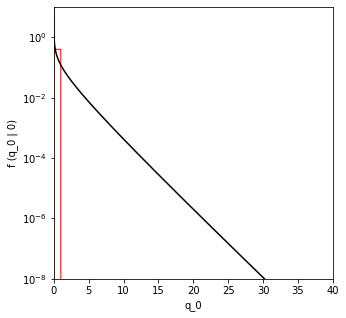

In [22]:
""" Recreat fig 3 (a) on page 24. """

# Format axes
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlim([0, 40])
axes.set_xlabel('q_0')
axes.set_ylabel('f (q_0 | 0)')
plt.rcParams["figure.figsize"] = [5, 5]

# Plot f(q_0 | 0)
x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(pdf_mu0)(x) # get vector of pdf_mu0 applied to every element of x
plt.plot(x, pdfs, color="black")

# Plot b = 2 montecarlo
weights = np.ones_like(q_0s)/float(len(q_0s))
plt.hist(q_0s, bins=range(100000), weights=weights, histtype='step', color='red')

plt.show()

In [23]:
# Parameters
b = 10
tau = 1
mu = 0
s = 10 #
gen_num = 10_000

# Calculate expectations for m and n
E_m = tau * b
E_n = mu * s + b
print(f"E[m]: {E_m} E[n]: {E_n}")

# Calculate m and n values
ms = [poisson.ppf(random.uniform(0,1), E_m) for i in range(0, gen_num)]
ns = [poisson.ppf(random.uniform(0,1), E_n) for i in range(0, gen_num)]

# Compute q_0s
q_0s_mu0 =  [get_q_0(ns[i], ms[i]) for i in range(0, len(ns))]

E[m]: 10 E[n]: 10


ZeroDivisionError: division by zero

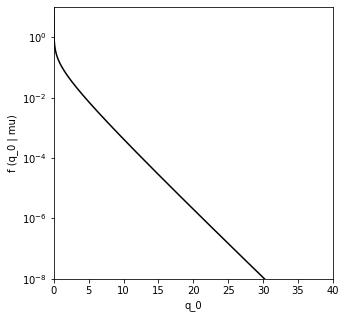

In [24]:
""" Recreat fig 3 (b) on page 24. """

# Format axes
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlim([0, 40])
axes.set_xlabel('q_0')
axes.set_ylabel('f (q_0 | mu)')
plt.rcParams["figure.figsize"] = [5, 5]

# Plot f(q_0 | 0)
x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(pdf_mu0)(x) # get vector of pdf_mu0 applied to every element of x
plt.plot(x, pdfs, color="black")

# Plot f(q_0 | 1)
x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(lambda x: pdf(x, 1))(x) # get vector of pdf applied to every element of x
plt.plot(x, pdfs, color="black")

# Plot b = 2 montecarlo
weights = np.ones_like(q_0s_mu0)/float(len(q_0s_mu0))
plt.hist(q_0s_mu0, bins=range(100), weights=weights, histtype='step', color='red')

plt.show()